# Регрессор на основе дерева решений - Цена б/у автомобиля

Дерево решений (Decision Tree Regressor) — это метод машинного обучения, который строит модель в виде древовидной структуры, где каждый внутренний узел представляет проверку значения признака, каждая ветвь — результат этой проверки, а каждый лист содержит предсказанное числовое значение.

## Импорт библиотек

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.preprocessing import LabelEncoder
import warnings
import time

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

## Загрузка и описание датасета

https://www.kaggle.com/datasets/deepcontractor/car-price-prediction-challenge

### Краткое описание
Датасет содержит информацию о подержанных автомобилях с различными техническими и эксплуатационными характеристиками. Задача — предсказание цены автомобиля (регрессия). Включает как числовые, так и категориальные признаки, описывающие марку, тип двигателя, габариты и другие параметры.

### Параметры (признаки)

| Признак | Описание |
|---------|----------|
| `ID` | Уникальный идентификатор записи |
| `Levy` | Налоговый сбор / пошлина на автомобиль (может содержать пропуски) |
| `Manufacturer` | Производитель (марка): Toyota, BMW, Mercedes и др. (категориальный) |
| `Model` | Модель автомобиля (категориальный, высокая кардинальность) |
| `Prod. year` | Год выпуска автомобиля |
| `Category` | Тип кузова: седан, джип, хэтчбек, купе и др. (категориальный) |
| `Leather interior` | Наличие кожаного салона: Yes / No (категориальный, бинарный) |
| `Fuel type` | Тип топлива: бензин, дизель, гибрид, газ, электро и др. (категориальный) |
| `Engine volume` | Объём двигателя (литры), может содержать пометку «Turbo» |
| `Mileage` | Пробег автомобиля (в км, строковый формат — требует очистки) |
| `Cylinders` | Количество цилиндров двигателя |
| `Gear box type` | Тип коробки передач: автомат, механика, вариатор, типтроник (категориальный) |
| `Drive wheels` | Тип привода: передний, задний, полный (категориальный) |
| `Doors` | Количество дверей (может быть строковым: «2-3», «4-5», «>5») |
| `Wheel` | Расположение руля: левый / правый (категориальный) |
| `Color` | Цвет кузова (категориальный) |
| `Airbags` | Количество подушек безопасности |

### Целевая переменная

| Переменная | Описание |
|------------|----------|
| `Price` | Цена автомобиля (в условных единицах / долларах). Непрерывная числовая — **задача регрессии** |


In [ ]:
# Загрузка датасета
df = pd.read_csv('car_price_prediction.csv')

print("=" * 60)
print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
print("=" * 60)
print(f"\nРазмер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"\nСтолбцы датасета:")
print(df.columns.tolist())

ИНФОРМАЦИЯ О ДАТАСЕТЕ

Размер датасета: 19237 строк, 18 столбцов

Столбцы датасета:
['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'Prod. year', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags']


In [52]:
print("\nПервые 10 строк датасета:")
df.head(10)


Первые 10 строк датасета:


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [53]:
print("\nИнформация о типах данных:")
df.info()


Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color       

In [54]:
print("\nСтатистическое описание числовых столбцов:")
df.describe()


Статистическое описание числовых столбцов:


,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [55]:
print("\nКоличество пропущенных значений:")
print(df.isnull().sum())


Количество пропущенных значений:
ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64


In [56]:
print("\nУникальные значения категориальных столбцов:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} уникальных значений")
    print(f"  Примеры: {df[col].unique()[:5]}")


Уникальные значения категориальных столбцов:

Levy: 559 уникальных значений
  Примеры: ['1399' '1018' '-' '862' '446']

Manufacturer: 65 уникальных значений
  Примеры: ['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI']

Model: 1590 уникальных значений
  Примеры: ['RX 450' 'Equinox' 'FIT' 'Escape' 'Santa FE']

Category: 11 уникальных значений
  Примеры: ['Jeep' 'Hatchback' 'Sedan' 'Microbus' 'Goods wagon']

Leather interior: 2 уникальных значений
  Примеры: ['Yes' 'No']

Fuel type: 7 уникальных значений
  Примеры: ['Hybrid' 'Petrol' 'Diesel' 'CNG' 'Plug-in Hybrid']

Engine volume: 107 уникальных значений
  Примеры: ['3.5' '3' '1.3' '2.5' '2']

Mileage: 7687 уникальных значений
  Примеры: ['186005 km' '192000 km' '200000 km' '168966 km' '91901 km']

Gear box type: 4 уникальных значений
  Примеры: ['Automatic' 'Tiptronic' 'Variator' 'Manual']

Drive wheels: 3 уникальных значений
  Примеры: ['4x4' 'Front' 'Rear']

Doors: 3 уникальных значений
  Примеры: ['04-May' '02-Mar' '>5']

Wheel: 2 уник

## Предварительная обработка датасета

In [57]:
# Создаём копию для обработки
data = df.copy()

print("=" * 60)
print("ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ")
print("=" * 60)

# --- Обработка столбца Price ---
# Убираем пробелы и нечисловые символы из Price
data['Price'] = data['Price'].astype(str).str.replace(' ', '').str.replace(',', '')
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

print(f"\nДо очистки Price: {df.shape[0]} строк")
data = data.dropna(subset=['Price'])
print(f"После очистки Price: {data.shape[0]} строк")

# Убираем выбросы по цене (слишком низкие и слишком высокие)
# Оставляем цены > 0
data = data[data['Price'] > 0]
print(f"После удаления нулевых цен: {data.shape[0]} строк")

ПРЕДВАРИТЕЛЬНАЯ ОБРАБОТКА ДАННЫХ

До очистки Price: 19237 строк
После очистки Price: 19237 строк
После удаления нулевых цен: 19237 строк


In [58]:
# --- Обработка столбца Mileage ---
# Mileage может содержать 'km' и пробелы
data['Mileage'] = data['Mileage'].astype(str).str.replace(' ', '').str.replace('km', '').str.replace(',', '')
data['Mileage'] = pd.to_numeric(data['Mileage'], errors='coerce')

# --- Обработка столбца Levy ---
data['Levy'] = data['Levy'].astype(str).str.replace('-', '0').str.replace(' ', '')
data['Levy'] = pd.to_numeric(data['Levy'], errors='coerce')
data['Levy'] = data['Levy'].fillna(0)

# --- Обработка столбца Engine volume ---
# Может содержать 'Turbo'
data['Turbo'] = data['Engine volume'].astype(str).str.contains('Turbo', case=False).astype(int)
data['Engine volume'] = data['Engine volume'].astype(str).str.replace('Turbo', '').str.strip()
data['Engine volume'] = pd.to_numeric(data['Engine volume'], errors='coerce')

# --- Обработка столбца Doors ---
data['Doors'] = data['Doors'].astype(str).str.extract('(\d+)').astype(float)

# --- Обработка столбца Prod. year ---
data['Age'] = 2025 - data['Prod. year']

print("\nОбработка числовых столбцов завершена")


Обработка числовых столбцов завершена


In [59]:
# --- Обработка столбца Cylinders ---
data['Cylinders'] = pd.to_numeric(data['Cylinders'], errors='coerce')

# --- Обработка столбца Airbags ---
data['Airbags'] = pd.to_numeric(data['Airbags'], errors='coerce')

# Удаляем ID и Prod. year (заменён на Age)
data = data.drop(columns=['ID', 'Prod. year'], errors='ignore')

print("\nСтолбцы после обработки:")
print(data.columns.tolist())


Столбцы после обработки:
['Price', 'Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Turbo', 'Age']


In [60]:
# --- Кодирование категориальных признаков ---
categorical_features = ['Manufacturer', 'Model', 'Category', 'Leather interior',
                        'Fuel type', 'Gear box type', 'Drive wheels', 'Color', 'Wheel']

label_encoders = {}
for col in categorical_features:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = data[col].astype(str)
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le
        print(f"Закодирован столбец '{col}': {le.classes_[:5]}...")

print(f"\nКоличество закодированных столбцов: {len(label_encoders)}")

Закодирован столбец 'Manufacturer': ['ACURA' 'ALFA ROMEO' 'ASTON MARTIN' 'AUDI' 'BENTLEY']...
Закодирован столбец 'Model': ['09-Mar' '100' '100 NX' '1000' '1111']...
Закодирован столбец 'Category': ['Cabriolet' 'Coupe' 'Goods wagon' 'Hatchback' 'Jeep']...
Закодирован столбец 'Leather interior': ['No' 'Yes']...
Закодирован столбец 'Fuel type': ['CNG' 'Diesel' 'Hybrid' 'Hydrogen' 'LPG']...
Закодирован столбец 'Gear box type': ['Automatic' 'Manual' 'Tiptronic' 'Variator']...
Закодирован столбец 'Drive wheels': ['4x4' 'Front' 'Rear']...
Закодирован столбец 'Color': ['Beige' 'Black' 'Blue' 'Brown' 'Carnelian red']...
Закодирован столбец 'Wheel': ['Left wheel' 'Right-hand drive']...

Количество закодированных столбцов: 9


In [61]:
# Удаляем оставшиеся пропуски
print(f"\nПропуски до финальной очистки:")
print(data.isnull().sum()[data.isnull().sum() > 0])

data = data.dropna()
print(f"\nИтоговый размер датасета: {data.shape[0]} строк, {data.shape[1]} столбцов")


Пропуски до финальной очистки:
Series([], dtype: int64)

Итоговый размер датасета: 19237 строк, 18 столбцов


In [62]:
# Удаляем выбросы по цене с помощью IQR
Q1 = data['Price'].quantile(0.05)
Q3 = data['Price'].quantile(0.95)
data_clean = data[(data['Price'] >= Q1) & (data['Price'] <= Q3)].copy()

print(f"\nРазмер после удаления выбросов по цене (5-95 перцентиль): {data_clean.shape[0]} строк")
print(f"Диапазон цен: {data_clean['Price'].min():.0f} - {data_clean['Price'].max():.0f}")


Размер после удаления выбросов по цене (5-95 перцентиль): 17377 строк
Диапазон цен: 314 - 49459


In [63]:
print("\nИтоговый датасет:")
data_clean.head(10)


Итоговый датасет:


,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
0,13328,1399,32,1242,4,1,2,3.5,186005,6.0,0,0,4.0,0,12,12,0,15
1,16621,1018,8,658,4,0,5,3.0,192000,6.0,2,0,4.0,0,1,8,0,14
2,8467,0,21,684,3,0,5,1.3,200000,4.0,3,1,4.0,1,1,2,0,19
3,3607,862,16,661,4,1,2,2.5,168966,4.0,0,0,4.0,0,14,0,0,14
4,11726,446,21,684,3,1,5,1.3,91901,4.0,0,1,4.0,0,12,4,0,11
5,39493,891,23,1305,4,1,1,2.0,160931,4.0,0,1,4.0,0,14,4,0,9
6,1803,761,58,1154,3,1,2,1.8,258909,4.0,0,1,4.0,0,14,12,0,15
7,549,751,23,1334,9,1,5,2.4,216118,4.0,0,1,4.0,0,7,12,0,12
8,1098,394,58,435,9,1,2,2.5,398069,4.0,0,1,4.0,0,1,12,0,11
9,26657,0,32,1235,4,1,5,3.5,128500,6.0,0,0,4.0,0,12,12,0,18


In [64]:
print("\nСтатистика итогового датасета:")
data_clean.describe()


Статистика итогового датасета:


,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo,Age
count,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,1.737700e+04,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000,17377.000000
mean,14967.378316,624.177131,33.242792,853.449445,6.355355,0.713184,3.430397,2.273528,1.494966e+06,4.531047,0.539852,0.926857,3.921793,0.077113,7.854118,6.583127,0.095529,14.306612
std,11494.106835,561.826501,17.900290,413.001406,2.796574,0.452288,1.810517,0.845669,4.751440e+07,1.144677,0.897506,0.558710,0.410828,0.266779,5.343265,4.272582,0.293952,5.580115
min,314.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,5.000000
25%,6272.000000,0.000000,21.000000,526.000000,4.000000,0.000000,2.000000,1.800000,7.384200e+04,4.000000,0.000000,1.000000,4.000000,0.000000,1.000000,4.000000,0.000000,11.000000
50%,13172.000000,642.000000,32.000000,834.000000,7.000000,1.000000,5.000000,2.000000,1.289650e+05,4.000000,0.000000,1.000000,4.000000,0.000000,8.000000,6.000000,0.000000,13.000000
75%,20800.000000,891.000000,54.000000,1226.000000,9.000000,1.000000,5.000000,2.500000,1.895710e+05,4.000000,1.000000,1.000000,4.000000,0.000000,12.000000,12.000000,0.000000,16.000000
max,49459.000000,11714.000000,64.000000,1589.000000,10.000000,1.000000,6.000000,20.000000,2.147484e+09,16.000000,3.000000,2.000000,5.000000,1.000000,15.000000,16.000000,1.000000,72.000000


## Тепловая карта корреляций (Heatmap)

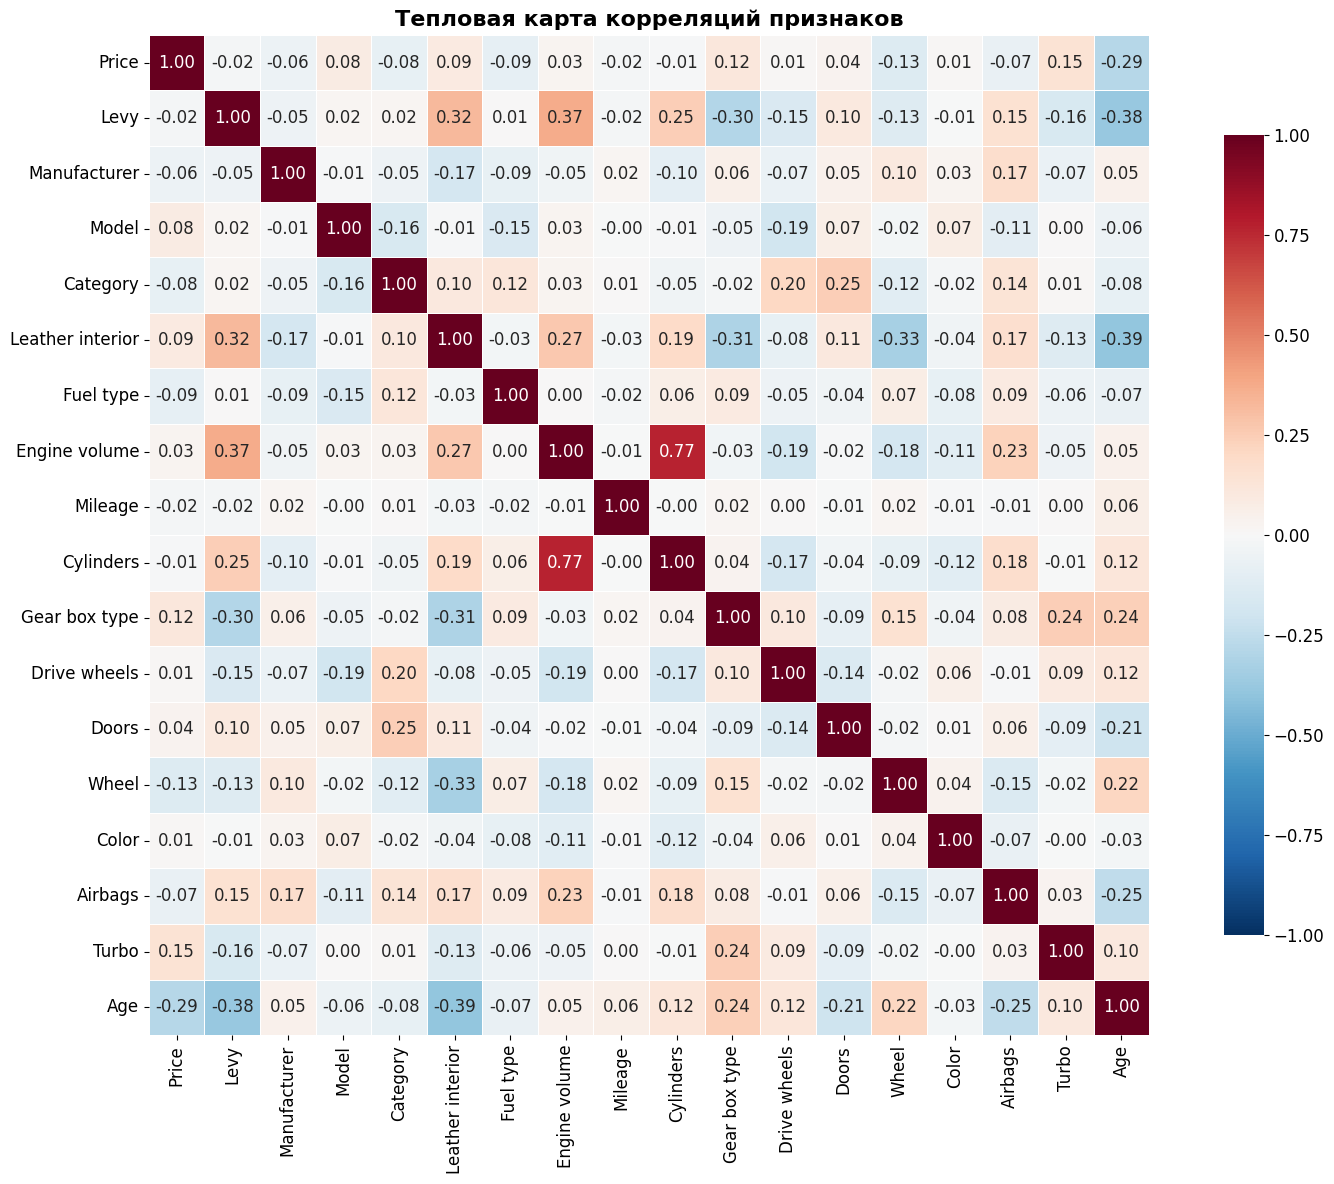

In [65]:
plt.figure(figsize=(16, 12))

correlation_matrix = data_clean.corr()

# Тепловая карта
sns.heatmap(correlation_matrix,
            annot=True,
            fmt='.2f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.8},
            vmin=-1, vmax=1)

plt.title('Тепловая карта корреляций признаков', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [87]:
# Корреляция признаков с целевой переменной Price
print("\nКорреляция признаков с ценой (Price):")
price_corr = correlation_matrix['Price'].drop('Price').sort_values(ascending=False)
print(price_corr.to_string())


Корреляция признаков с ценой (Price):
Turbo               0.146329
Gear box type       0.115453
Leather interior    0.086582
Model               0.083727
Doors               0.037448
Engine volume       0.025481
Color               0.011707
Drive wheels        0.009425
Cylinders          -0.014045
Levy               -0.016175
Mileage            -0.017057
Manufacturer       -0.061942
Airbags            -0.074537
Category           -0.078454
Fuel type          -0.092390
Wheel              -0.133122
Age                -0.286199


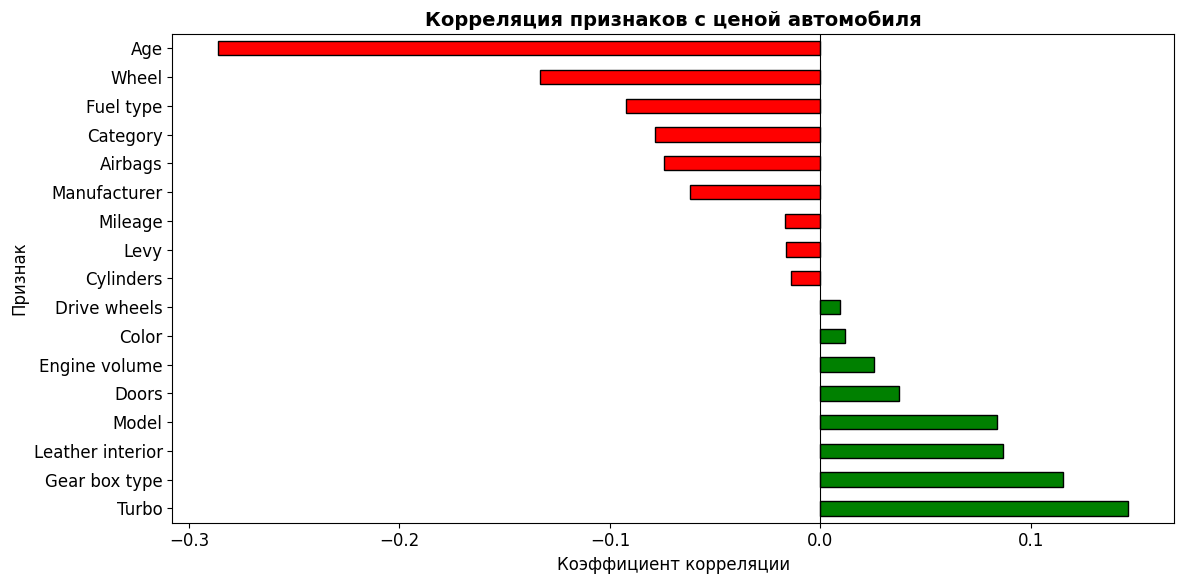

In [67]:
# Визуализация корреляции с ценой
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in price_corr.values]
price_corr.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Корреляция признаков с ценой автомобиля', fontsize=14, fontweight='bold')
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Признак')
plt.axvline(x=0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

## Обучение модели

In [68]:
print("=" * 70)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ")
print("=" * 70)

X = data_clean.drop(columns=['Price'])
y = data_clean['Price']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")
print(f"Список признаков: {X.columns.tolist()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nОбучающая выборка: {X_train.shape[0]} строк")
print(f"Тестовая выборка:  {X_test.shape[0]} строк")

ПОДГОТОВКА ДАННЫХ ДЛЯ ОБУЧЕНИЯ
Признаки (X): (17377, 17)
Целевая переменная (y): (17377,)
Список признаков: ['Levy', 'Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Turbo', 'Age']

Обучающая выборка: 13901 строк
Тестовая выборка:  3476 строк


In [69]:
print("=" * 70)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ DecisionTreeRegressor")
print("=" * 70)

# dt_param_grid = {
#     'max_depth': [5, 10, 15, 20],
#     'min_samples_split': [5, 10, 20],
#     'min_samples_leaf': [3, 5, 10],
#     'max_features': ['sqrt', 'log2', None]
# }
dt_param_grid = {
    'max_depth': [20],
    'min_samples_split': [20],
    'min_samples_leaf': [3],
    'max_features': [None]
}

dt_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
dt_grid_search.fit(X_train, y_train)
dt_time = time.time() - start_time

print(f"\nВремя подбора: {dt_time:.1f} сек")
print(f"Лучшие параметры: {dt_grid_search.best_params_}")
print(f"Лучший R² (кросс-валидация): {dt_grid_search.best_score_:.4f}")

ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ DecisionTreeRegressor
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Время подбора: 17.8 сек
Лучшие параметры: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20}
Лучший R² (кросс-валидация): 0.6813


In [70]:
print("=" * 70)
print("ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ RandomForestRegressor")
print("=" * 70)

# rf_param_grid = {
#     'max_depth': [10, 15, 20],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [3, 5],
#     'max_features': ['sqrt', 'log2']
# }
rf_param_grid = {
    'max_depth': [20],
    'min_samples_split': [5],
    'min_samples_leaf': [3],
    'max_features': ['sqrt']
}

rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_estimators=300),
    param_grid=rf_param_grid,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
rf_grid_search.fit(X_train, y_train)
rf_time = time.time() - start_time

print(f"\nВремя подбора: {rf_time:.1f} сек")
print(f"Лучшие параметры: {rf_grid_search.best_params_}")
print(f"Лучший R² (кросс-валидация): {rf_grid_search.best_score_:.4f}")

ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ RandomForestRegressor
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Время подбора: 434.6 сек
Лучшие параметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5}
Лучший R² (кросс-валидация): 0.7661


In [71]:
# --- Decision Tree ---
dt_best = dt_grid_search.best_estimator_
print(f"\nDecision Tree Regressor:")
print(f"  Параметры: {dt_grid_search.best_params_}")
print(f"  Глубина дерева: {dt_best.get_depth()}")
print(f"  Количество листьев: {dt_best.get_n_leaves()}")

# --- Random Forest ---
rf_best = rf_grid_search.best_estimator_
print(f"\nRandom Forest Regressor:")
print(f"  Параметры: {rf_grid_search.best_params_}")
print(f"  Количество деревьев: {rf_best.n_estimators}")


Decision Tree Regressor:
  Параметры: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20}
  Глубина дерева: 20
  Количество листьев: 1330

Random Forest Regressor:
  Параметры: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5}
  Количество деревьев: 300


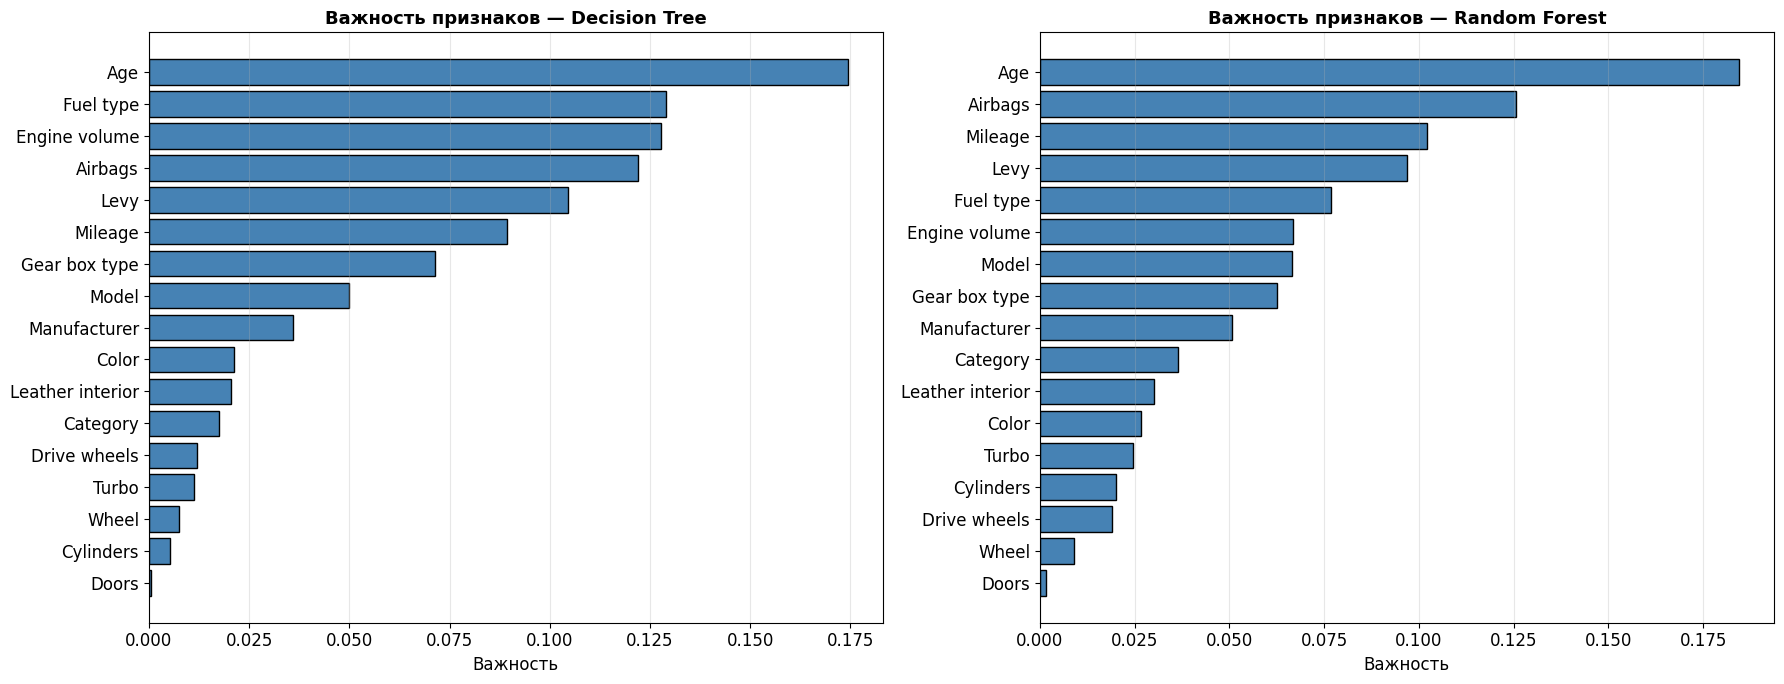

In [72]:
# Важность признаков для обеих моделей
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, model, name in zip(axes, [dt_best, rf_best],
                            ['Decision Tree', 'Random Forest']):
    fi = pd.DataFrame({
        'Признак': X.columns,
        'Важность': model.feature_importances_
    }).sort_values(by='Важность', ascending=True)

    ax.barh(fi['Признак'], fi['Важность'], color='steelblue', edgecolor='black')
    ax.set_title(f'Важность признаков — {name}', fontweight='bold', fontsize=13)
    ax.set_xlabel('Важность')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

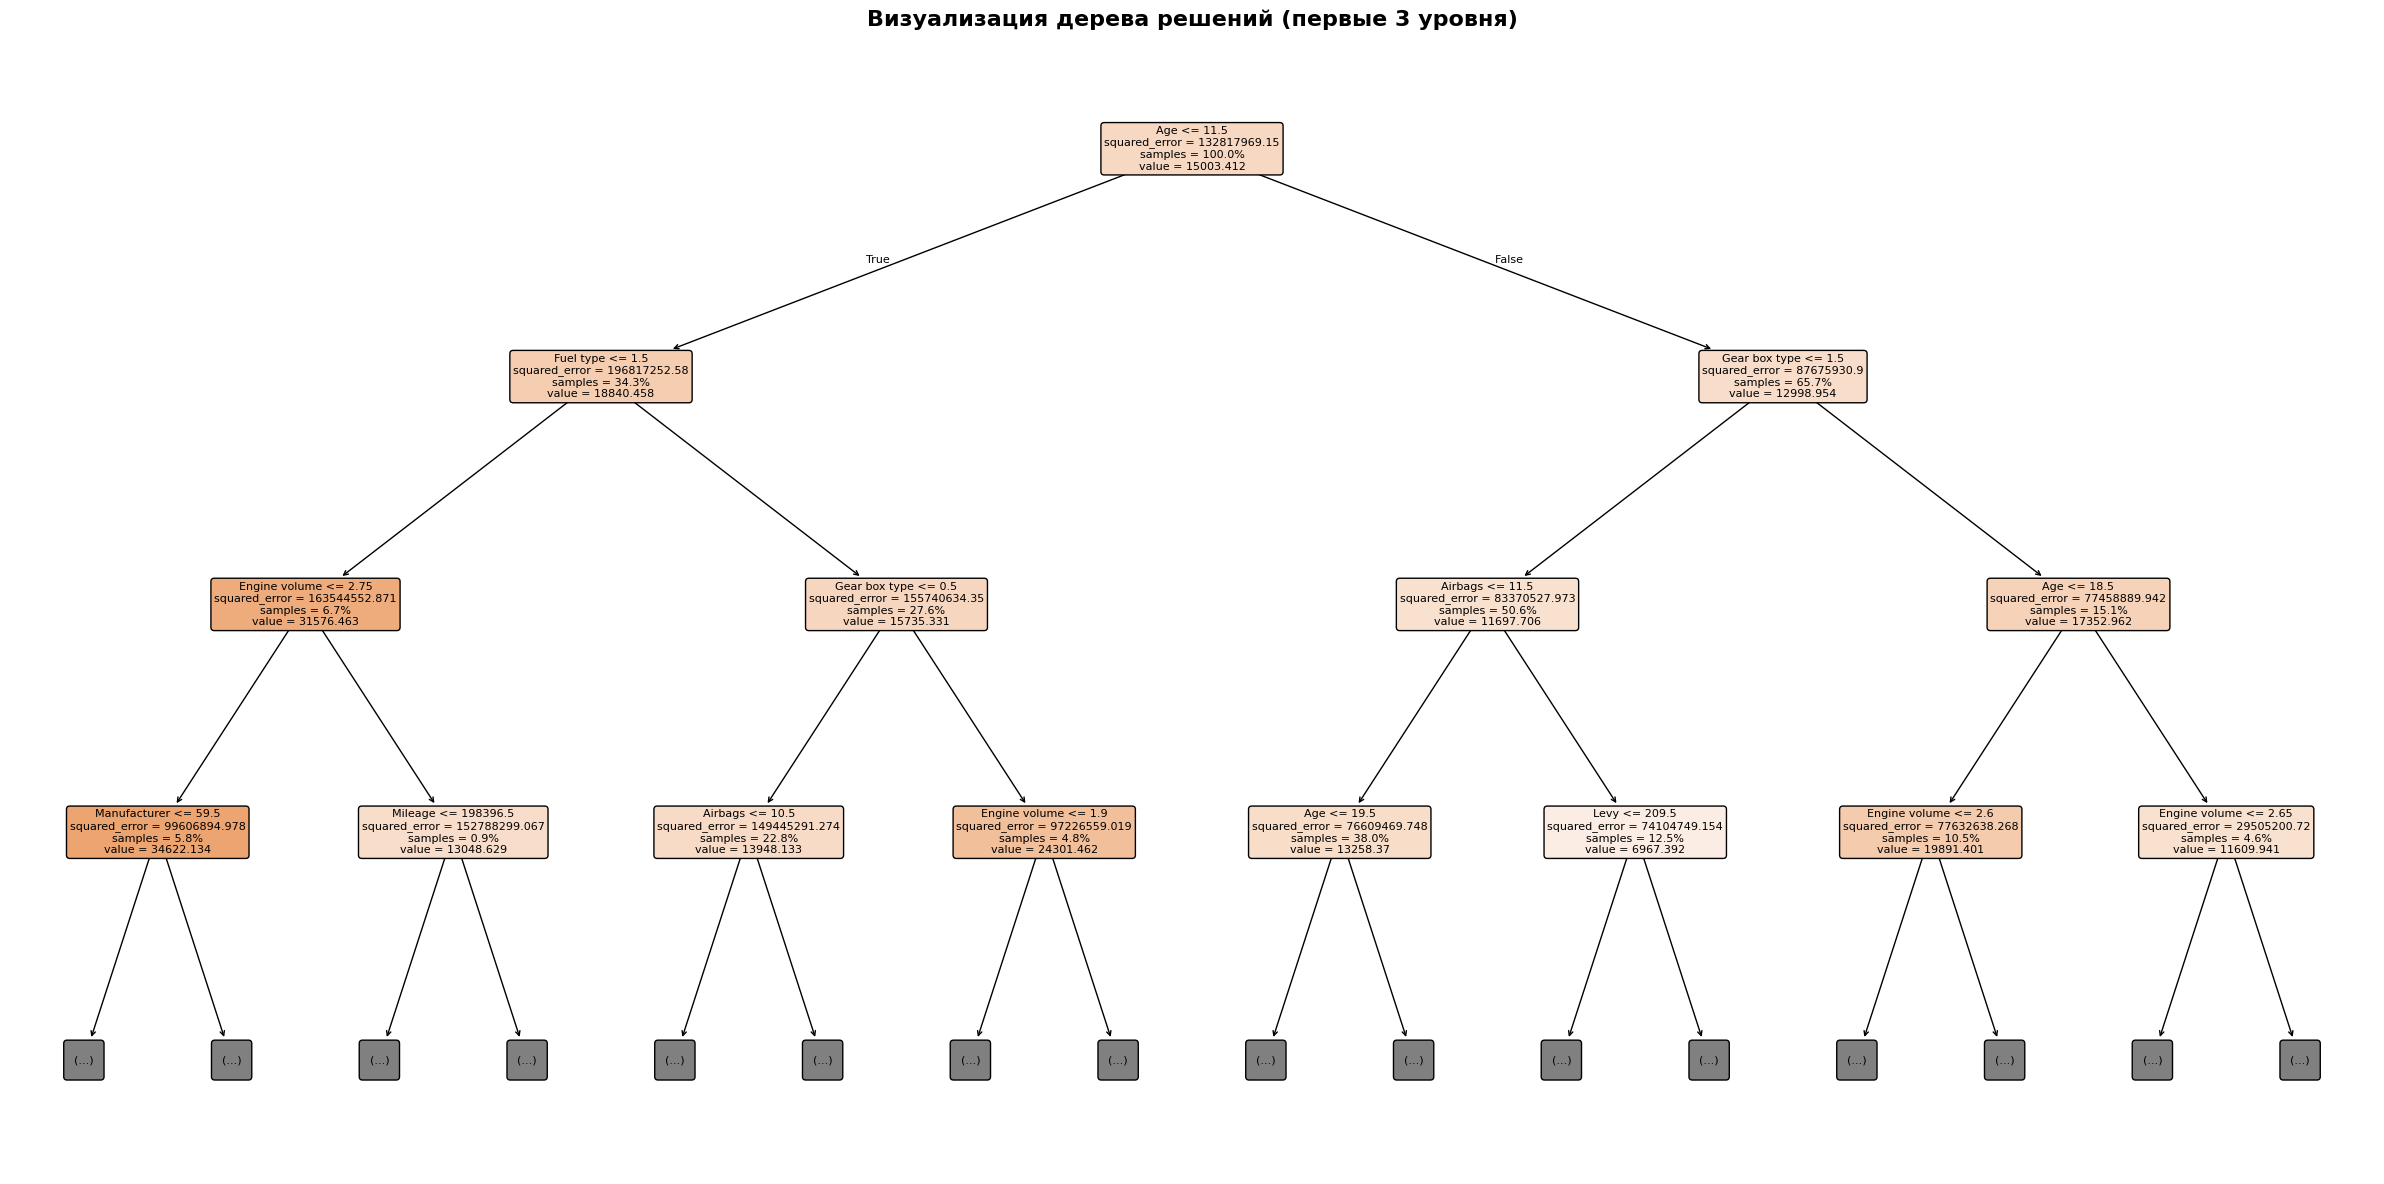

In [73]:
# Визуализация дерева решений (первые 3 уровня)
plt.figure(figsize=(24, 12))
plot_tree(
    dt_best,
    feature_names=X.columns.tolist(),
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8,
    proportion=True
)
plt.title('Визуализация дерева решений (первые 3 уровня)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Прогнозы модели

In [74]:
print("=" * 70)
print("ПРОГНОЗЫ МОДЕЛЕЙ")
print("=" * 70)

# Предсказания
y_pred_dt_train = dt_best.predict(X_train)
y_pred_dt_test = dt_best.predict(X_test)

y_pred_rf_train = rf_best.predict(X_train)
y_pred_rf_test = rf_best.predict(X_test)

ПРОГНОЗЫ МОДЕЛЕЙ


In [75]:
# Сравнение предсказаний (первые 15 записей)
comparison = pd.DataFrame({
    'Реальная цена': y_test.values[:15],
    'DT предсказание': y_pred_dt_test[:15].round(0),
    'DT ошибка (%)': (np.abs(y_test.values[:15] - y_pred_dt_test[:15]) / y_test.values[:15] * 100).round(1),
    'RF предсказание': y_pred_rf_test[:15].round(0),
    'RF ошибка (%)': (np.abs(y_test.values[:15] - y_pred_rf_test[:15]) / y_test.values[:15] * 100).round(1),
})

print("\nСравнение реальных и предсказанных цен (первые 15 записей):")
print(comparison.to_string(index=False))


Сравнение реальных и предсказанных цен (первые 15 записей):
 Реальная цена  DT предсказание  DT ошибка (%)  RF предсказание  RF ошибка (%)
         10976          13799.0           25.7          11636.0            6.0
           314           2841.0          804.8           3438.0          994.9
          1550           6868.0          343.1           7992.0          415.6
         12544           9147.0           27.1          11057.0           11.9
         14113          13799.0            2.2          11423.0           19.1
         29793          26526.0           11.0          25035.0           16.0
           627           3202.0          410.7           4070.0          549.2
         30891          31008.0            0.4          31971.0            3.5
         44843          43213.0            3.6          40690.0            9.3
         12500          10875.0           13.0          13375.0            7.0
          8311           8667.0            4.3          10958.0       

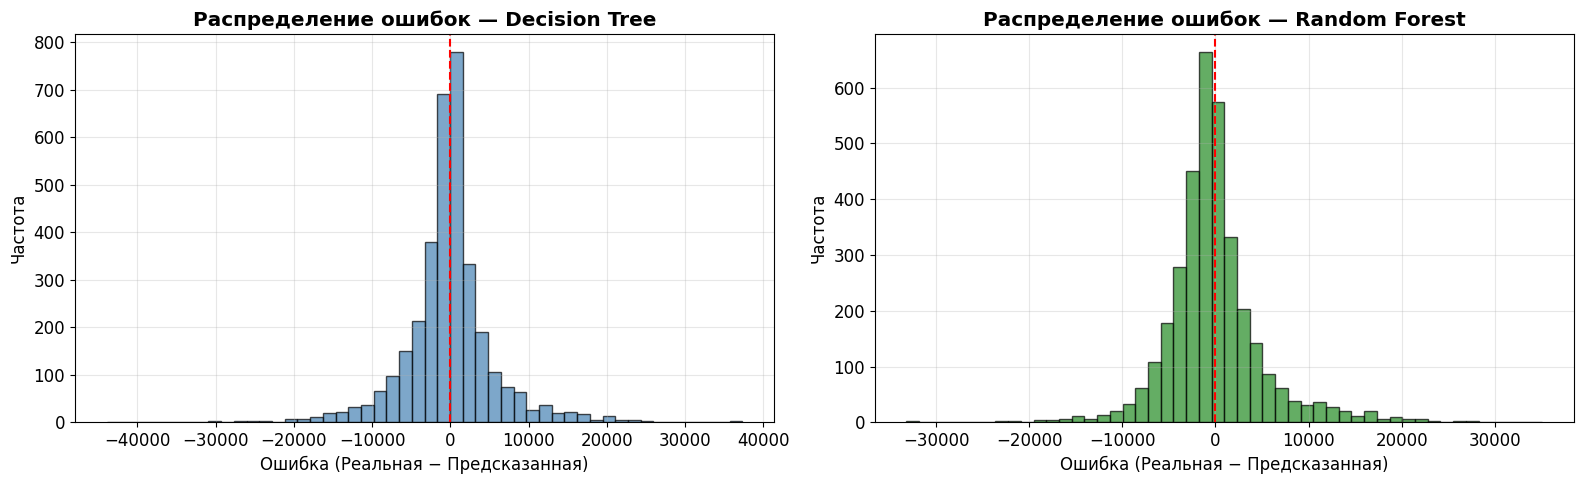

In [76]:
# Распределение ошибок
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, errors, name, color in zip(
    axes,
    [y_test - y_pred_dt_test, y_test - y_pred_rf_test],
    ['Decision Tree', 'Random Forest'],
    ['steelblue', 'forestgreen']
):
    ax.hist(errors, bins=50, color=color, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    ax.set_title(f'Распределение ошибок — {name}', fontweight='bold')
    ax.set_xlabel('Ошибка (Реальная − Предсказанная)')
    ax.set_ylabel('Частота')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Метрики качества и графики результатов

In [77]:
print("=" * 70)
print("МЕТРИКИ КАЧЕСТВА МОДЕЛЕЙ (РЕГРЕССИЯ)")
print("=" * 70)


def compute_metrics(y_true, y_pred):
    """Вычисление регрессионных метрик."""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R²': r2_score(y_true, y_pred),
        'MAPE (%)': mean_absolute_percentage_error(y_true, y_pred) * 100
    }


# Метрики для обеих моделей
metrics = {
    'DT (обучение)': compute_metrics(y_train, y_pred_dt_train),
    'DT (тест)': compute_metrics(y_test, y_pred_dt_test),
    'RF (обучение)': compute_metrics(y_train, y_pred_rf_train),
    'RF (тест)': compute_metrics(y_test, y_pred_rf_test),
}

metrics_df = pd.DataFrame(metrics).T
print("\n")
print(metrics_df.round(4).to_string())

МЕТРИКИ КАЧЕСТВА МОДЕЛЕЙ (РЕГРЕССИЯ)


                     MAE           MSE       RMSE      R²  MAPE (%)
DT (обучение)  2683.5351  1.948867e+07  4414.5969  0.8533   61.7042
DT (тест)      3831.7367  3.824065e+07  6183.9027  0.7041  110.2242
RF (обучение)  2660.2068  1.680482e+07  4099.3679  0.8735   82.7803
RF (тест)      3536.6011  2.848881e+07  5337.4914  0.7796  129.9492


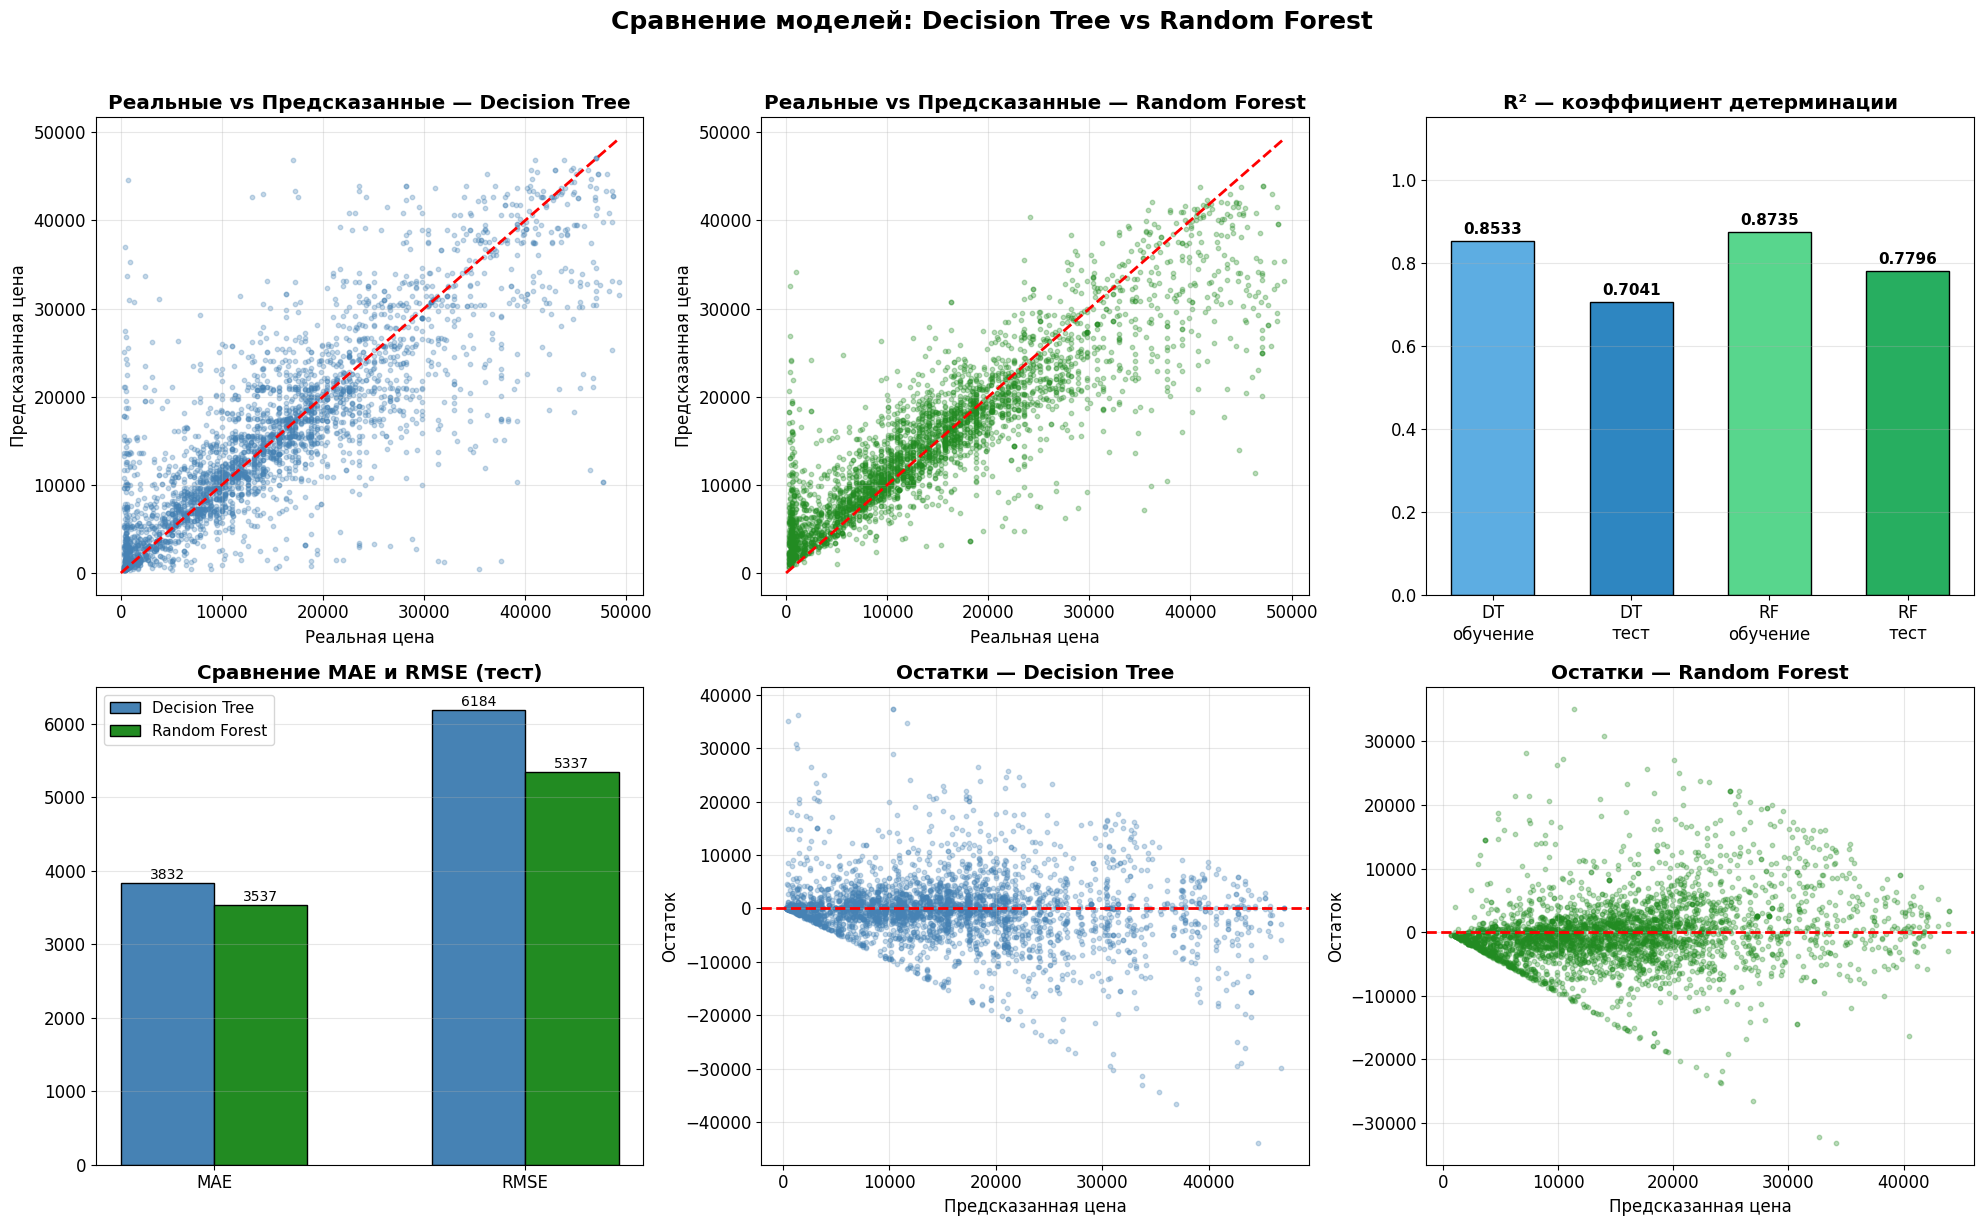

In [85]:
# === ОСНОВНЫЕ ГРАФИКИ ===

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# --- 1. Реальные vs Предсказанные — Decision Tree ---
ax = axes[0, 0]
ax.scatter(y_test, y_pred_dt_test, alpha=0.3, s=10, color='steelblue')
max_val = max(y_test.max(), y_pred_dt_test.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
ax.set_xlabel('Реальная цена')
ax.set_ylabel('Предсказанная цена')
ax.set_title('Реальные vs Предсказанные — Decision Tree', fontweight='bold')
ax.grid(True, alpha=0.3)

# --- 2. Реальные vs Предсказанные — Random Forest ---
ax = axes[0, 1]
ax.scatter(y_test, y_pred_rf_test, alpha=0.3, s=10, color='forestgreen')
max_val = max(y_test.max(), y_pred_rf_test.max())
ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2)
ax.set_xlabel('Реальная цена')
ax.set_ylabel('Предсказанная цена')
ax.set_title('Реальные vs Предсказанные — Random Forest', fontweight='bold')
ax.grid(True, alpha=0.3)

# --- 3. Сравнение R² ---
ax = axes[0, 2]
r2_vals = [metrics['DT (обучение)']['R²'], metrics['DT (тест)']['R²'],
           metrics['RF (обучение)']['R²'], metrics['RF (тест)']['R²']]
r2_labels = ['DT\nобучение', 'DT\nтест', 'RF\nобучение', 'RF\nтест']
colors_r2 = ['#5DADE2', '#2E86C1', '#58D68D', '#27AE60']
bars = ax.bar(r2_labels, r2_vals, color=colors_r2, edgecolor='black', width=0.6)
ax.set_ylim(0, 1.15)
ax.set_title('R² — коэффициент детерминации', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, r2_vals):
    ax.annotate(f'{val:.4f}', xy=(bar.get_x() + bar.get_width() / 2, val),
                xytext=(0, 5), textcoords="offset points", ha='center',
                fontsize=11, fontweight='bold')

# --- 4. Сравнение MAE и RMSE ---
ax = axes[1, 0]
metrics_names = ['MAE', 'RMSE']
dt_vals = [metrics['DT (тест)']['MAE'], metrics['DT (тест)']['RMSE']]
rf_vals = [metrics['RF (тест)']['MAE'], metrics['RF (тест)']['RMSE']]
x_pos = np.arange(len(metrics_names))
width = 0.3
bars1 = ax.bar(x_pos - width / 2, dt_vals, width, label='Decision Tree',
               color='steelblue', edgecolor='black')
bars2 = ax.bar(x_pos + width / 2, rf_vals, width, label='Random Forest',
               color='forestgreen', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_names, fontsize=12)
ax.set_title('Сравнение MAE и RMSE (тест)', fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
for bar in list(bars1) + list(bars2):
    height = bar.get_height()
    ax.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

# --- 5. Остатки — Decision Tree ---
ax = axes[1, 1]
residuals_dt = y_test - y_pred_dt_test
ax.scatter(y_pred_dt_test, residuals_dt, alpha=0.3, s=10, color='steelblue')
ax.axhline(y=0, color='red', linewidth=2, linestyle='--')
ax.set_xlabel('Предсказанная цена')
ax.set_ylabel('Остаток')
ax.set_title('Остатки — Decision Tree', fontweight='bold')
ax.grid(True, alpha=0.3)

# --- 6. Остатки — Random Forest ---
ax = axes[1, 2]
residuals_rf = y_test - y_pred_rf_test
ax.scatter(y_pred_rf_test, residuals_rf, alpha=0.3, s=10, color='forestgreen')
ax.axhline(y=0, color='red', linewidth=2, linestyle='--')
ax.set_xlabel('Предсказанная цена')
ax.set_ylabel('Остаток')
ax.set_title('Остатки — Random Forest', fontweight='bold')
ax.grid(True, alpha=0.3)

plt.suptitle('Сравнение моделей: Decision Tree vs Random Forest',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()